In [1]:
import numpy as np
import timeit
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from time import time

# 一、 Basic Requirement

# CRR binomial tree model

In [2]:
def call(ST,K):
    return np.maximum(ST-K, 0)

def put(ST,K):
    return np.maximum(K-ST, 0)

def BS(S, K, T, r, b, sigma, option):
    d1 = (np.log(S/K) + (b+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - (sigma*np.sqrt(T))
    if option == 'call':
        return S*norm.cdf(d1)*np.exp((b - r) * T) - K*np.exp(-r*T)*norm.cdf(d2)
    elif option == 'put':
        return -S*norm.cdf(-d1)*np.exp((b - r) * T) + K*np.exp(-r*T)*norm.cdf(-d2)

def binomial_tree(S, K, T, r, b, sigma, N, method, option, Astyle=None):
    dt = T/N # time increament
    df = np.exp(-r*dt) # discount factor

    payoff = {'call': call, 'put': put}[option]

    if method == 'CRR':
        u = np.exp(sigma*np.sqrt(dt))
        d = 1/u
        q = (np.exp(b*dt)-d) / (u-d)

    stock_path = np.zeros((N+1, N+1))
    stock_path[0,0] = S
    for i in range(1, N+1):
        for j in range(i+1):
            stock_path[i,j] = S * u**(i-j) * d**j

    option_value = np.maximum(payoff(stock_path[N], K), 0)
    for i in range(N, 0, -1):
        for j in range(i):
            option_value[j] = (q * option_value[j] + (1-q) * option_value[j+1]) * df
            if Astyle == True:
                option_value[j] = max(option_value[j], payoff(stock_path[i-1, j], K))
    return option_value[0]

## CRR - American-style plain vanilla calls

## 買權變數輸入 ( parameters inputs )

In [3]:
print("S = ", end = '')
S = float(input())
print("K = ", end = '')
K = float(input())
print("T = ", end = '')
T = float(input())
print("r = ", end = '')
r = float(input())
print("q = ", end = '') #考慮股利率
q = float(input())
b = r-q
print("sigma = ", end = '')
sigma = float(input())

S = 120
K = 100
T = 1
r = 0.03
q = 0.01
sigma = 0.2


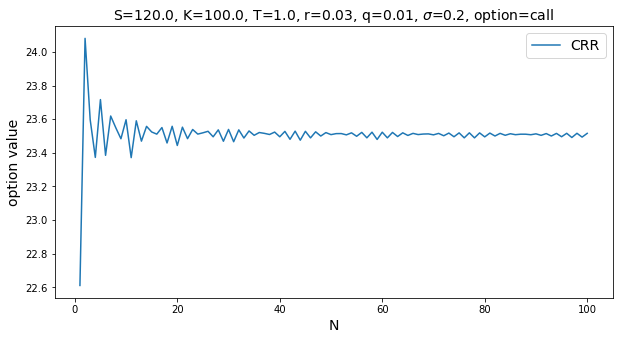

In [4]:
option = 'call'
N = np.arange(1, 101)
crr_res = []
for n in N:
    crr_res.append(binomial_tree(S, K, T, r, b, sigma, n, 'CRR', option, True))

plt.figure(figsize=(10,5))
plt.plot(N, crr_res, label='CRR')
plt.title(f'S={S}, K={K}, T={T}, r={r}, q={q}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

In [5]:
print("CRR美式買權價格 =", binomial_tree(S, K, T, r, b, sigma, n, 'CRR', 'call', True))

CRR美式買權價格 = 23.515580746925654


## CRR - American-style plain vanilla puts

## 賣權變數輸入 ( parameters inputs )

In [6]:
print("S = ", end = '')
S = float(input())
print("K = ", end = '')
K = float(input())
print("T = ", end = '')
T = float(input())
print("r = ", end = '')
r = float(input())
print("q = ", end = '') #考慮股利率
q = float(input())
b = r-q
print("sigma = ", end = '')
sigma = float(input())

S = 100
K = 120
T = 1
r = 0.03
q = 0.01
sigma = 0.2


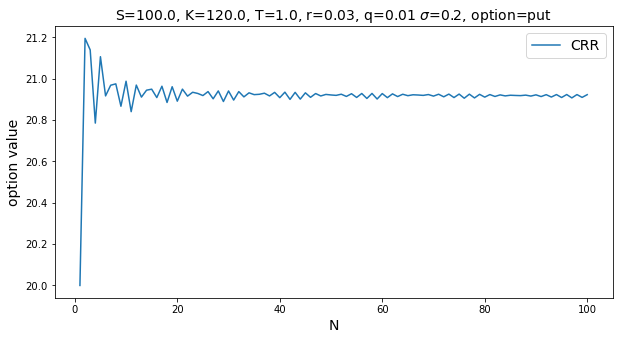

In [7]:
option = 'put'
N = np.arange(1, 101)
crr_res = []
for n in N:
    crr_res.append(binomial_tree(S, K, T, r, b, sigma, n, 'CRR', option, True))

plt.figure(figsize=(10,5))
plt.plot(N, crr_res, label='CRR')
plt.title(f'S={S}, K={K}, T={T}, r={r}, q={q} $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

In [8]:
print("CRR美式賣權價格 =", binomial_tree(S, K, T, r, b, sigma, n, 'CRR', 'put', True))

CRR美式賣權價格 = 20.922756752592996


# Efficient Analytic Approximation (BAW)

## BAW - American-style plain vanilla calls

In [9]:
print("S = ", end = '')
S = float(input())
print("X = ", end = '')
X = float(input())
print("t = ", end = '')
t = float(input())
print("r = ", end = '')
r = float(input())
print("q = ", end = '') #考慮股利率
q = float(input())
b = r-q
print("sigma = ", end = '')
Sigma = float(input())
print("iteration max error = ", end = '')
_ITERATION_MAX_ERROR = float(input())

S = 120
X = 100
t = 1
r = 0.03
q = 0.01
sigma = 0.2
iteration max error = 0.00001


In [10]:
def BS_call(S, X, t, r, b, Sigma):
    d1 = (np.log(S/X) + (b + 0.5 * Sigma**2)*t)/(Sigma * np.sqrt(t))
    d2 = d1 - Sigma * np.sqrt(t)
    Call = S * np.exp((b - r) * t)*stats.norm.cdf(d1,0.0,1.0) - X * np.exp(-r*t) * stats.norm.cdf(d2,0.0,1.0)
    return Call

In [11]:
# Newton‘s Method
def _Kc(X, t, r, b, Sigma):

    N = 2 * b / Sigma**2
    M = 2 * r / Sigma**2
    q2u = (-1 * (N - 1) + ((N - 1)**2 + 4 * M)**0.5) / 2  # p27.
    su = X / (1 - 1 / q2u)                                # p27.
    h2 = -1 * (b * t + 2 * Sigma * np.sqrt(t)) * X / (su - X)  # p31.
    Si = X + (su - X) * (1 - np.exp(h2))                       # p31.

    K = (1 - np.exp(-1 * r * t))
    d1 = (np.log(Si / X) + (b + Sigma**2 / 2) * t) / (Sigma * np.sqrt(t))
    q2 = (-1 * (N - 1) + ((N - 1)**2 + 4 * M / K)**0.5) / 2  # p16.
    LHS = Si - X
    RHS = BS_call(Si, X, t, r, b, Sigma) + (1 - np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0)) * Si / q2  # p23.
    bi = np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0) * (1 - 1 / q2) + (1 - np.exp((b - r) * t) * stats.norm.pdf(d1,0.0,1.0) / (Sigma * np.sqrt(t))) / q2  # p25. 

    E = _ITERATION_MAX_ERROR
    
    while np.abs(LHS - RHS) / X > E:        # p26.
        Si = (X + RHS - bi * Si) / (1 - bi) # p25.
        d1 = (np.log(Si / X) + (b + Sigma**2 / 2) * t) / (Sigma * np.sqrt(t))
        LHS = Si - X
        RHS = BS_call(Si, X, t, r, b, Sigma) + (1 - np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0)) * Si / q2
        bi = np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0) * (1 - 1 / q2) + (1 - np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0) / (Sigma * np.sqrt(t))) / q2
    
    return Si

In [12]:
S_star = _Kc(X, t, r, b, Sigma)

print("臨界股價 S* =", S_star)

臨界股價 S* = 345.40973737778353


In [13]:
# 臨界股價求出美式選擇權近似解
def _approximateAmericanCall(S, X, t, r, b, Sigma):
    '''
    Barone-Adesi And Whaley
    '''

    if b >= r:                               # 無股利發放
        return BS_call(S, X, t, r, b, Sigma)
    else:                                    # 有股利發放
        Sk = _Kc(X, t, r, b, Sigma)
        N = 2 * b / Sigma**2
        M = 2 * r / Sigma**2
        K = (1 - np.exp(-1 * r * t))
        d1 = (np.log(Sk / X) + (b + (Sigma**2) / 2) * t) / (Sigma * (t**0.5))
        q2 = (-1 * (N - 1) + ((N - 1)**2 + 4 * M / K))**0.5 / 2
        a2 = (Sk / q2) * (1 - np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0))  # P21.
        if S < Sk:
            return BS_call(S, X, t, r, b, Sigma) + a2 * (S / Sk)**q2  # 小於臨界股價 P21.
        else:
            return S - X                  

In [14]:
Amcall_price = _approximateAmericanCall(S, X, t, r, b, Sigma)
print("BAW美式買權價格 =", Amcall_price)

BAW美式買權價格 = 23.50612543670543


## BAW - American-style plain vanilla puts

In [15]:
print("S = ", end = '')
S = float(input())
print("X = ", end = '')
X = float(input())
print("t = ", end = '')
t = float(input())
print("r = ", end = '')
r = float(input())
print("q = ", end = '') #考慮股利率
q = float(input())
b = r-q
print("sigma = ", end = '')
Sigma = float(input())
print("iteration max error = ", end = '')
_ITERATION_MAX_ERROR = float(input())


S = 100
X = 120
t = 1
r = 0.03
q = 0.01
sigma = 0.2
iteration max error = 0.00001


In [16]:
def BS_put(S, X, t, r, b, Sigma):
    d1 = (np.log(S/X) + (b + 0.5 * Sigma**2)*t)/(Sigma * np.sqrt(t))
    d2 = d1 - Sigma * np.sqrt(t)
    Put = -S* np.exp((b - r) * t)*stats.norm.cdf(-d1,0.0,1.0) + X*np.exp(-r*t)* stats.norm.cdf(-d2,0.0,1.0)
    return Put


In [17]:
# Newton‘s Method
def _Kp(X, t, r, b, Sigma):

    N = 2 * b / Sigma**2
    M = 2 * r / Sigma**2
    q1u = (-1 * (N - 1) - ((N - 1)**2 + 4 * M)**0.5) / 2
    su = X / (1 - 1 / q1u)    
    h1 = (b * t - 2 * Sigma * np.sqrt(t)) * X / (X-su)
    Si = su + (X - su) * np.exp(h1)
                         
    K = (1 - np.exp(-1 * r * t))
    d1 = (np.log(Si / X) + (b + Sigma**2 / 2) * t) / (Sigma * np.sqrt(t))
    q1 = (-1 * (N - 1) - ((N - 1)**2 + 4 * M / K)**0.5) / 2  
     
    LHS = X - Si
    RHS = BS_put(Si, X, t, r, b, Sigma) - (1 - np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0)) * Si / q1  
    bi = -1*np.exp((b - r) * t) * (stats.norm.cdf(-d1,0.0,1.0)) * (1 - 1 / q1) - (1 + np.exp((b - r) * t) * stats.norm.pdf(-d1,0.0,1.0) / (Sigma * np.sqrt(t))) / q1
    E = _ITERATION_MAX_ERROR
    
    while np.abs(LHS - RHS) / X > E:        # p26.
        Si = (X - RHS + bi * Si) / (1 + bi) # p25.
        d1 = (np.log(Si / X) + (b + Sigma**2 / 2) * t) / (Sigma * np.sqrt(t))
        LHS = X - Si
        RHS = BS_put(Si, X, t, r, b, Sigma) - (1 - np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0)) * Si / q1  
        bi = -np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0) * (1 - 1 / q1) - (1 + np.exp((b - r) * t) * stats.norm.pdf(-d1,0.0,1.0) / (Sigma * np.sqrt(t))) / q1
    
    return Si

In [18]:
S_star = _Kp(X, t, r, b, Sigma)

print("臨界股價 S* =", S_star)

臨界股價 S* = 91.18973001254987


In [19]:
def _approximateAmericanPut(S, X, t, r, b, Sigma):
    '''
    Barone-Adesi And Whaley
    '''

    if b >= r:                               # 無股利發放
        return BS_put(S, X, t, r, b, Sigma)
    else:                                    # 有股利發放
        Sk = _Kp(X, t, r, b, Sigma)
        N = 2 * b / Sigma**2
        M = 2 * r / Sigma**2
        K = (1 - np.exp(-1 * r * t))
        d1 = (np.log(Sk / X) + (b + (Sigma**2) / 2) * t) / (Sigma * (t**0.5))
        q1 = (-1 * (N - 1) - ((N - 1)**2 + 4 * M / K)**0.5) / 2
        a1 = -(Sk / q1) * (1 - np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0))  
        
        if S > Sk:
            return BS_put(S, X, t, r, b, Sigma) + a1 * (S / Sk)**q1  # 小於臨界股價 P21.
        else:
            return X - S                  

In [20]:
Amput_price = _approximateAmericanPut(S, X, t, r, b, Sigma)
print("BAW美式賣權價格 =", Amput_price)

BAW美式賣權價格 = 20.827345928013525


# Least-squares Monte Carlo simulation¶

In [21]:
def stock_simu(S, T, r, q, sigma, N, M, seed):
    dt = T / N
    np.random.seed(seed)  
    paths = np.zeros((N + 1, M))
    paths[0] = S

    for t in range(1, N + 1):
        Z = np.random.standard_normal(int(M/2))
        Z = np.concatenate((Z, -Z))
        paths[t] = paths[t - 1] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def least_squares_MC(S, K, T, r, q, sigma, M, N, order, option, seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, q, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)  #zeros_like:生成和payoffs一樣大小的np.array，但裡面每個elements都是0
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t]>=0
        reg = np.polyfit(stock_paths[t][in_the_money], exercise_values[t+1][in_the_money]*df, order)
        
        C = np.polyval(reg, stock_paths[t][in_the_money])
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df  # ~ :波浪符代表把boolean值顛倒過來
    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5

## LSMC - American-style plain vanilla calls

## 買權變數輸入 ( parameter inputs )

In [22]:
print("S = ", end = '')
S = float(input())
print("K = ", end = '')
K = float(input())
print("T = ", end = '')
T = float(input())
print("r = ", end = '')
r = float(input())
print("q = ", end = '') #考慮股利率
q = float(input())
b = r-q
print("sigma = ", end = '')
sigma = float(input())

S = 120
K = 100
T = 1
r = 0.03
q = 0.01
sigma = 0.2


Pricing Value
-----------------
Monte Carlo mean: 23.191
Monte Carlo std: 0.043


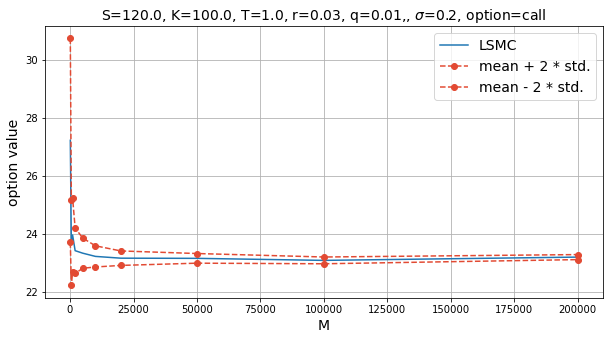

In [23]:
N = 100
option = 'call'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r, q, sigma, n, N, 5, 'call')
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='LSMC')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, q={q},, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

In [24]:
option = 'call'
N = np.arange(10, 101,10)
crr_res = []
crr_time = []
for n in N:
    t1 = time()
    crr = (binomial_tree(S, K, T, r, b, sigma, n, 'CRR', option, True))
    t2 = time()
    crr_res.append(crr)
    crr_time.append(t2-t1)

M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
N = 100
mc_mean = []
mc_std = []
mc_time = []
for n in M:
    t1 = time()
    m, s = least_squares_MC(S, K, T, r, q, sigma, n, N, 5, 'call')
    t2 = time()
    mc_time.append(t2-t1)
    mc_mean.append(m)
    mc_std.append(s)

In [25]:
bin_res = pd.DataFrame({
    'N': np.arange(10, 101, 10),
    'CRR': crr_res,
    'CRR time': crr_time
})

lsmc_res = pd.DataFrame({
    'N': [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000],
    'LSMC': mc_mean,
    'LSMC time': mc_time
})

print('Binomial Tree')
print(bin_res.T)
print('============================================================================')
print('Least Square Monte Carlo')
print(lsmc_res.T)

Binomial Tree
                  0          1          2          3          4          5  \
N         10.000000  20.000000  30.000000  40.000000  50.000000  60.000000   
CRR       23.596534  23.443512  23.538808  23.495208  23.508047  23.522389   
CRR time   0.000991   0.000997   0.001958   0.004025   0.005985   0.011931   

                  6          7          8           9  
N         70.000000  80.000000  90.000000  100.000000  
CRR       23.506709  23.494716  23.512689   23.515581  
CRR time   0.011970   0.016984   0.017957    0.023945  
Least Square Monte Carlo
                    0           1            2            3            4  \
N          100.000000  500.000000  1000.000000  2000.000000  5000.000000   
LSMC        27.215292   23.692966    23.951150    23.412383    23.325430   
LSMC time    0.016917    0.020986     0.029878     0.063923     0.110762   

                      5             6             7              8  \
N          10000.000000  20000.000000  50000.0000

## American-style plain vanilla puts

## 賣權變數輸入 ( parameter inputs )

In [27]:
print("S = ", end = '')
S = float(input())
print("K = ", end = '')
K = float(input())
print("T = ", end = '')
T = float(input())
print("r = ", end = '')
r = float(input())
print("q = ", end = '') #考慮股利率
q = float(input())
b = r-q
print("sigma = ", end = '')
sigma = float(input())


S = 100
K = 120
T = 1
r = 0.03
q = 0.01
sigma = 0.2


Pricing Value
-----------------
Monte Carlo mean: 20.841
Monte Carlo std: 0.023


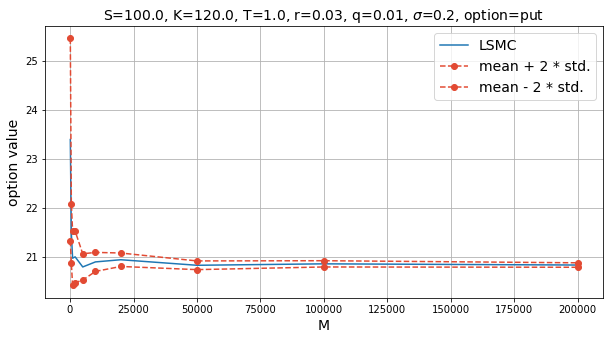

In [28]:
N = 100
option = 'put'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r, q, sigma, n, N, 5, 'put')
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='LSMC')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, q={q}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

In [29]:
option = 'put'
N = np.arange(10, 101,10)
crr_res = []
crr_time = []
for n in N:
    t1 = time()
    crr = (binomial_tree(S, K, T, r, b, sigma, n, 'CRR', option, True))
    t2 = time()
    crr_res.append(crr)
    crr_time.append(t2-t1)

M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
N = 100
mc_mean = []
mc_std = []
mc_time = []
for n in M:
    t1 = time()
    m, s = least_squares_MC(S, K, T, r, q, sigma, n, N, 5, 'put')
    t2 = time()
    mc_time.append(t2-t1)
    mc_mean.append(m)
    mc_std.append(s)

In [30]:
bin_res = pd.DataFrame({
    'N': np.arange(10, 101, 10),
    'CRR': crr_res,
    'CRR time': crr_time
})

lsmc_res = pd.DataFrame({
    'N': [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000],
    'LSMC': mc_mean,
    'LSMC time': mc_time
})

print('Binomial Tree')
print(bin_res.T)
print('============================================================================')
print('Least Square Monte Carlo')
print(lsmc_res.T)

Binomial Tree
                  0          1          2          3          4          5  \
N         10.000000  20.000000  30.000000  40.000000  50.000000  60.000000   
CRR       20.987833  20.891298  20.940613  20.908260  20.921342  20.928014   
CRR time   0.000000   0.000997   0.002992   0.003989   0.007979   0.013962   

                  6          7          8           9  
N         70.000000  80.000000  90.000000  100.000000  
CRR       20.915786  20.910818  20.921913   20.922757  
CRR time   0.013998   0.015964   0.018953    0.024888  
Least Square Monte Carlo
                    0           1            2            3            4  \
N          100.000000  500.000000  1000.000000  2000.000000  5000.000000   
LSMC        23.399038   21.489116    20.980151    21.007236    20.801658   
LSMC time    0.015956    0.020944     0.029922     0.062393     0.106722   

                      5             6             7              8  \
N          10000.000000  20000.000000  50000.0000

# 二、Replace the OLS in LSMC with following regression methods

# 1. Ridge Regression

In [31]:
from sklearn.linear_model import Ridge

In [32]:
def least_squares_MC_ridge(S, K, T, r, q, sigma, M, N, order, option, alpha = 1, seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, q, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t] >= 0

        X = stock_paths[t][in_the_money].reshape(-1, 1)
        y = exercise_values[t+1][in_the_money] * df

        ridge_reg = Ridge(alpha=alpha)
        ridge_reg.fit(X, y)

        C = ridge_reg.predict(X)
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df

    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5

## 1.1 American-style plain vanilla calls - Ridge

Pricing Value
-----------------
Monte Carlo mean: 22.712
Monte Carlo std: 0.078


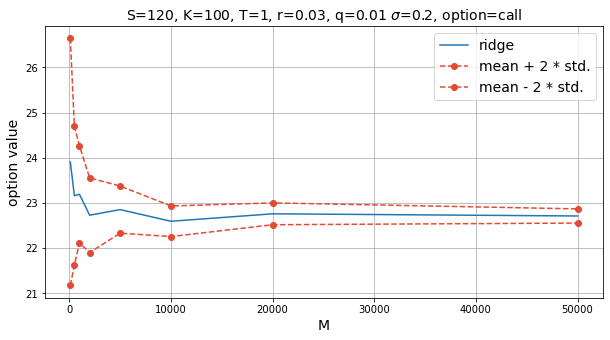

In [33]:
S = 120
K = 100
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 50
option = 'call'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC_ridge(S, K, T, r, q, sigma, n, N, 5, option,seed=123)
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='ridge')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, q={q} $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

## 1.2 American-style plain vanilla puts - Ridge

Pricing Value
-----------------
Monte Carlo mean: 20.388
Monte Carlo std: 0.048


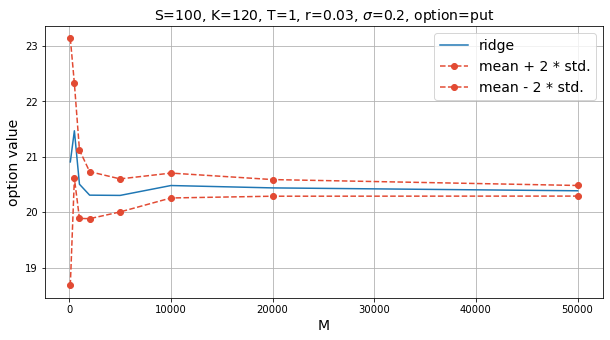

In [34]:
S = 100
K = 120
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 50
option = 'put'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC_ridge(S, K, T, r, q, sigma, n, N, 5, option,seed=123)
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='ridge')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

# 2. Lasso Regression

In [35]:
from sklearn.linear_model import Lasso

In [36]:
def least_squares_MC_lasso(S, K, T, r, q, sigma, M, N, order, option, alpha = 0.001, seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, q, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t] >= 0

        X = stock_paths[t][in_the_money].reshape(-1, 1)
        y = exercise_values[t+1][in_the_money] * df

        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(X, y)

        C = lasso_reg.predict(X)
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df

    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5

## 2.1 American-style plain vanilla calls - Lasso

Pricing Value
-----------------
Monte Carlo mean: 22.711
Monte Carlo std: 0.078


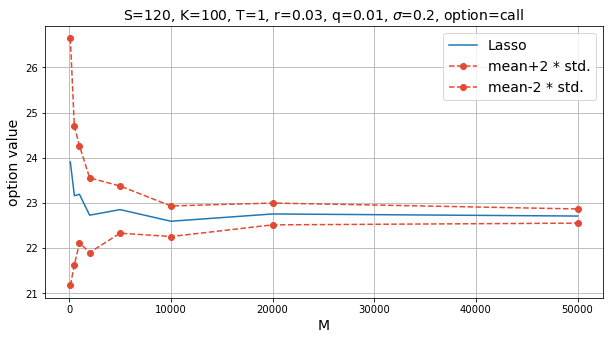

In [37]:
S = 120
K = 100
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 50
option = 'call'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC_lasso(S, K, T, r, q, sigma, n, N, 5, option, seed=123)
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='Lasso')
plt.plot(M, mc_mean+2*mc_std, label='mean+2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean-2*mc_std, label='mean-2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, q={q}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

## 2.2 American-style plain vanilla puts - Lasso

Pricing Value
-----------------
Monte Carlo mean: 20.386
Monte Carlo std: 0.048


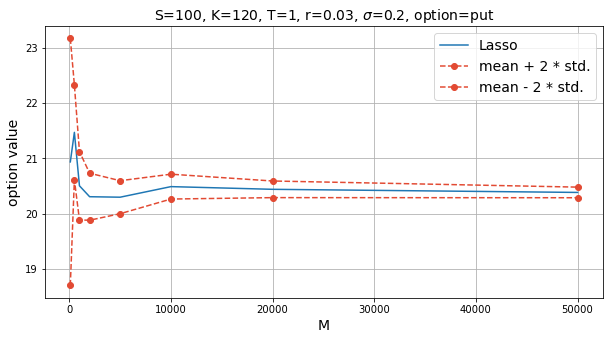

In [38]:
S = 100
K = 120
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 50
option = 'put'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC_lasso(S, K, T, r, q, sigma, n, N, 5, option, seed=123)
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='Lasso')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)



# compare with Ridge、Lasso、OLS - call

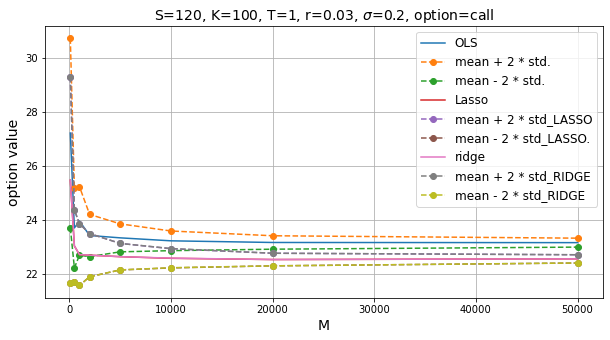

In [39]:
S = 120
K = 100
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 100
option = 'call'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]

# OLS
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r, q, sigma, n, N, 5, 'call')
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

# lasso
mc_mean_lasso = []
mc_std_lasso = []
for n in M:
    m, s = least_squares_MC_lasso(S, K, T, r, q, sigma, n, N, 5, option, seed=123)
    mc_mean_lasso.append(m)
    mc_std_lasso.append(s)

mc_mean_lasso = np.array(mc_mean_lasso)
mc_std_lasso = np.array(mc_std_lasso)

# Ridge
mc_mean_Ridge = []
mc_std_Ridge = []
for n in M:
    m, s = least_squares_MC_ridge(S, K, T, r, q, sigma, n, N, 5, option,seed=123)
    mc_mean_Ridge.append(m)
    mc_std_Ridge.append(s)

mc_mean_Ridge = np.array(mc_mean_Ridge)
mc_std_Ridge = np.array(mc_std_Ridge)



plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='OLS')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.',  marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.',  marker='o', linestyle='--')

plt.plot(M, mc_mean_lasso, label='Lasso')
plt.plot(M, mc_mean_lasso + 2*mc_std_lasso, label='mean + 2 * std_LASSO',  marker='o', linestyle='--')
plt.plot(M, mc_mean_lasso - 2*mc_std_lasso, label='mean - 2 * std_LASSO.', marker='o', linestyle='--')

plt.plot(M, mc_mean_Ridge, label='ridge')
plt.plot(M, mc_mean_Ridge + 2*mc_std_Ridge, label='mean + 2 * std_RIDGE',  marker='o', linestyle='--')
plt.plot(M, mc_mean_Ridge - 2*mc_std_Ridge, label='mean - 2 * std_RIDGE',  marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=12)


# compare with Ridge、Lasso、OLS - put


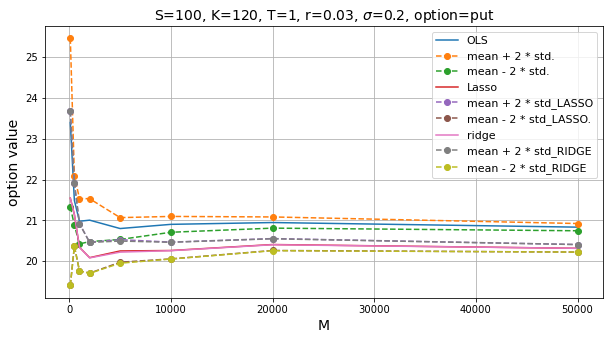

In [40]:
S = 100
K = 120
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 100
option = 'put'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]

# OLS
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r, q, sigma, n, N, 5, 'put')
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

# lasso
mc_mean_lasso = []
mc_std_lasso = []
for n in M:
    m, s = least_squares_MC_lasso(S, K, T, r, q, sigma, n, N, 5, option, seed=123)
    mc_mean_lasso.append(m)
    mc_std_lasso.append(s)

mc_mean_lasso = np.array(mc_mean_lasso)
mc_std_lasso = np.array(mc_std_lasso)

# Ridge
mc_mean_Ridge = []
mc_std_Ridge = []
for n in M:
    m, s = least_squares_MC_ridge(S, K, T, r, q, sigma, n, N, 5, option,seed=123)
    mc_mean_Ridge.append(m)
    mc_std_Ridge.append(s)

mc_mean_Ridge = np.array(mc_mean_Ridge)
mc_std_Ridge = np.array(mc_std_Ridge)



plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='OLS')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.',  marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.',  marker='o', linestyle='--')

plt.plot(M, mc_mean_lasso, label='Lasso')
plt.plot(M, mc_mean_lasso + 2*mc_std_lasso, label='mean + 2 * std_LASSO',  marker='o', linestyle='--')
plt.plot(M, mc_mean_lasso - 2*mc_std_lasso, label='mean - 2 * std_LASSO.', marker='o', linestyle='--')

plt.plot(M, mc_mean_Ridge, label='ridge')
plt.plot(M, mc_mean_Ridge + 2*mc_std_Ridge, label='mean + 2 * std_RIDGE',  marker='o', linestyle='--')
plt.plot(M, mc_mean_Ridge - 2*mc_std_Ridge, label='mean - 2 * std_RIDGE',  marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=11)


# 3. Weighted least square Regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [42]:
def least_squares_MC_wls(S, K, T, r, q, sigma, M, N, order, option, seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, q, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)  
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t] >= 0
        X = np.vander(stock_paths[t][in_the_money], order + 1)  # 生成 Vandermonde 矩陣
        y = exercise_values[t+1][in_the_money] * df

        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        model_var = LinearRegression()
        model_var.fit(X, y)
        residuals = y - model_var.predict(X)
        weights = 1 / (np.abs(residuals) + 1e-10)
        model_wls = LinearRegression()
        model_wls.fit(X, y, sample_weight=weights)

        C = model_wls.predict(X)
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df  

    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5

## 3.1 American-style plain vanilla calls - Weighted

Pricing Value
-----------------
Monte Carlo mean: 23.231
Monte Carlo std: 0.084


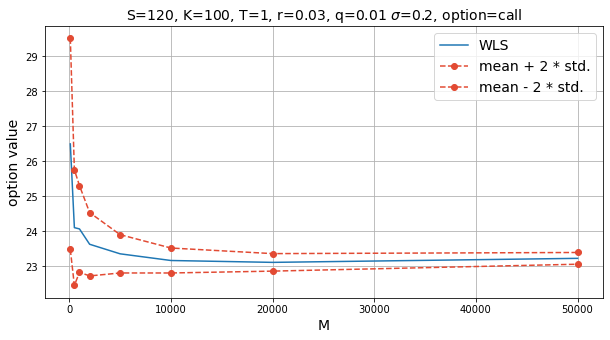

In [43]:
S = 120
K = 100
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 50
option = 'call'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC_wls(S, K, T, r, q, sigma, n, N, 5, 'call')
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='WLS')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, q={q} $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

## 3.2 American-style plain vanilla puts - Weighted

Pricing Value
-----------------
Monte Carlo mean: 20.760
Monte Carlo std: 0.052


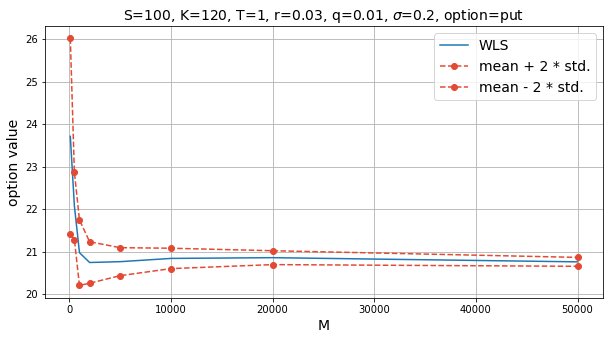

In [44]:
S = 100
K = 120
T = 1
r = 0.03
sigma = 0.2
N = 50
option = 'put'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC_wls(S, K, T, r, q, sigma, n, N, 5, 'put')
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='WLS')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, q={q}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

# compare with Ridge、Lasso、WLS、OLS - call

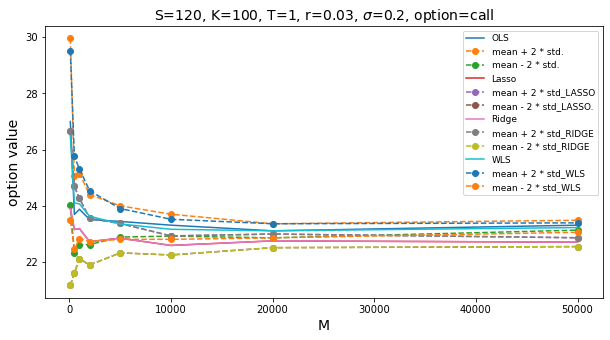

In [45]:
S = 120
K = 100
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 50
option = 'call'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]

# OLS
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r, q, sigma, n, N, 5, 'call')
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

# lasso
mc_mean_lasso = []
mc_std_lasso = []
for n in M:
    m, s = least_squares_MC_lasso(S, K, T, r, q, sigma, n, N, 5, option, seed=123)
    mc_mean_lasso.append(m)
    mc_std_lasso.append(s)

mc_mean_lasso = np.array(mc_mean_lasso)
mc_std_lasso = np.array(mc_std_lasso)

# Ridge
mc_mean_Ridge = []
mc_std_Ridge = []
for n in M:
    m, s = least_squares_MC_ridge(S, K, T, r, q, sigma, n, N, 5, option,seed=123)
    mc_mean_Ridge.append(m)
    mc_std_Ridge.append(s)

mc_mean_Ridge = np.array(mc_mean_Ridge)
mc_std_Ridge = np.array(mc_std_Ridge)

# WLS
mc_mean_WLS = []
mc_std_WLS = []
for n in M:
    m, s = least_squares_MC_wls(S, K, T, r, q, sigma, n, N, 5, 'call')
    mc_mean_WLS.append(m)
    mc_std_WLS.append(s)

mc_mean_WLS = np.array(mc_mean_WLS)
mc_std_WLS = np.array(mc_std_WLS)


plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='OLS')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.',  marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.',  marker='o', linestyle='--')

plt.plot(M, mc_mean_lasso, label='Lasso')
plt.plot(M, mc_mean_lasso + 2*mc_std_lasso, label='mean + 2 * std_LASSO',  marker='o', linestyle='--')
plt.plot(M, mc_mean_lasso - 2*mc_std_lasso, label='mean - 2 * std_LASSO.', marker='o', linestyle='--')

plt.plot(M, mc_mean_Ridge, label='Ridge')
plt.plot(M, mc_mean_Ridge + 2*mc_std_Ridge, label='mean + 2 * std_RIDGE',  marker='o', linestyle='--')
plt.plot(M, mc_mean_Ridge - 2*mc_std_Ridge, label='mean - 2 * std_RIDGE',  marker='o', linestyle='--')
plt.grid()

plt.plot(M, mc_mean_WLS, label='WLS')
plt.plot(M, mc_mean_WLS + 2*mc_std_WLS, label='mean + 2 * std_WLS',  marker='o', linestyle='--')
plt.plot(M, mc_mean_WLS - 2*mc_std_WLS, label='mean - 2 * std_WLS',  marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=9)


# compare with Ridge、Lasso、WLS、OLS - put

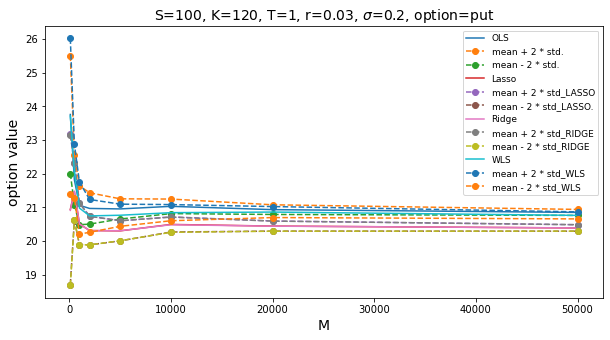

In [46]:
S = 100
K = 120
T = 1
r = 0.03
q = 0.01
b = r - q
sigma = 0.2
N = 50
option = 'put'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]

# OLS
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r, q, sigma, n, N, 5, 'put')
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

# lasso
mc_mean_lasso = []
mc_std_lasso = []
for n in M:
    m, s = least_squares_MC_lasso(S, K, T, r, q, sigma, n, N, 5, option, seed=123)
    mc_mean_lasso.append(m)
    mc_std_lasso.append(s)

mc_mean_lasso = np.array(mc_mean_lasso)
mc_std_lasso = np.array(mc_std_lasso)

# Ridge
mc_mean_Ridge = []
mc_std_Ridge = []
for n in M:
    m, s = least_squares_MC_ridge(S, K, T, r, q, sigma, n, N, 5, option,seed=123)
    mc_mean_Ridge.append(m)
    mc_std_Ridge.append(s)

mc_mean_Ridge = np.array(mc_mean_Ridge)
mc_std_Ridge = np.array(mc_std_Ridge)

# WLS
mc_mean_WLS = []
mc_std_WLS = []
for n in M:
    m, s = least_squares_MC_wls(S, K, T, r, q, sigma, n, N, 5, 'put')
    mc_mean_WLS.append(m)
    mc_std_WLS.append(s)

mc_mean_WLS = np.array(mc_mean_WLS)
mc_std_WLS = np.array(mc_std_WLS)


plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='OLS')
plt.plot(M, mc_mean + 2*mc_std, label='mean + 2 * std.',  marker='o', linestyle='--')
plt.plot(M, mc_mean - 2*mc_std, label='mean - 2 * std.',  marker='o', linestyle='--')

plt.plot(M, mc_mean_lasso, label='Lasso')
plt.plot(M, mc_mean_lasso + 2*mc_std_lasso, label='mean + 2 * std_LASSO',  marker='o', linestyle='--')
plt.plot(M, mc_mean_lasso - 2*mc_std_lasso, label='mean - 2 * std_LASSO.', marker='o', linestyle='--')

plt.plot(M, mc_mean_Ridge, label='Ridge')
plt.plot(M, mc_mean_Ridge + 2*mc_std_Ridge, label='mean + 2 * std_RIDGE',  marker='o', linestyle='--')
plt.plot(M, mc_mean_Ridge - 2*mc_std_Ridge, label='mean - 2 * std_RIDGE',  marker='o', linestyle='--')
plt.grid()

plt.plot(M, mc_mean_WLS, label='WLS')
plt.plot(M, mc_mean_WLS + 2*mc_std_WLS, label='mean + 2 * std_WLS',  marker='o', linestyle='--')
plt.plot(M, mc_mean_WLS - 2*mc_std_WLS, label='mean - 2 * std_WLS',  marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=9)
